In [19]:
import numpy as np
import pandas as pd
# Import data from csv files
TestTT = pd.read_csv('Test.csv',parse_dates =["Time"], index_col ="Time")
BaseTT = pd.read_csv('Base.csv',parse_dates =["Time"], index_col ="Time")

TestTT = TestTT.sort_values(by=["Time"])
BaseTT = BaseTT.sort_values(by=["Time"])

In [20]:
InputValues = TestTT['Blue'].values
BaselineValues = BaseTT['PAR'].values

# Input data
InputShift = np.roll(InputValues, 1)
InputShift[0] = InputValues[0]  # Copy the first value back so division = 1

# Generate arrays which describe the rising and falling events of the signal
Rising = InputValues / InputShift
Falling = InputShift / InputValues

# Find places where both test points are tiny
LowPoints = (InputShift < 0.01) & (InputValues < 0.01)
# Set these tiny points to no change
Rising[LowPoints] = 1
Rising[Rising < 1] = 1  # Set all negative changes to steady state
Rising[np.isnan(Rising)] = 0 # Set all nan points to 1

# Set these tiny points to no change
Falling[LowPoints] = 1
Falling[Falling < 1] = 1
Falling[np.isnan(Falling)] = 0 # Set all nan points to 1

# Generate blank array
GainCorrectExp = np.ones(len(InputValues))

# Take log base 2 of scale of change, round this to get integer
RisingExp = np.log2(Rising)
FallingExp = np.log2(Falling)

# Only look at gain changes greater or equal to ~8x
RisingExp[RisingExp < 2.75] = 0
FallingExp[FallingExp < 2.75] = 0

PrevGain = 0
NewGain = 0

# Iterate over whole array
for i in range(len(InputValues)):
    if RisingExp[i] > 0:  # If there is a significant rising event, reduce the gain correction
        NewGain = PrevGain - RisingExp[i]
    elif FallingExp[i] > 0:  # If there is a significant falling event, increase the gain correction
        NewGain = FallingExp[i]
    elif InputValues[i] == 0:  # Return to min gain at dark periods
        NewGain = 0
    else:
        NewGain = PrevGain  # If no significant events, continue with previous gain
    
    NewGain = max(NewGain, 0)  # Clamp to 0
    PrevGain = NewGain  # Update gain values
    GainCorrectExp[i] = NewGain

# Calculate corrected output
CorrectedOutput = InputValues * (2 ** GainCorrectExp)

# Reduce any excessive gain instances
while np.sum(CorrectedOutput > 1) > 0:  # Repeat reducing gain until no corrected values exceed 1
    GainCorrectExp[CorrectedOutput > 1] -= 1  # Decrease gain for all instances where corrected output exceeds 1
    CorrectedOutput = InputValues * (2 ** GainCorrectExp)  # Update test values

OutputValues = InputValues * (2 ** GainCorrectExp)  # Calculate final output

TestTT['BlueCorr'] = OutputValues*2190 #Apply correction factor

C:\Users\schul\AppData\Local\Temp/ipykernel_21240/3351319459.py:9: RuntimeWarning: divide by zero encountered in true_divide
  Rising = InputValues / InputShift
C:\Users\schul\AppData\Local\Temp/ipykernel_21240/3351319459.py:9: RuntimeWarning: invalid value encountered in true_divide
  Rising = InputValues / InputShift
C:\Users\schul\AppData\Local\Temp/ipykernel_21240/3351319459.py:10: RuntimeWarning: divide by zero encountered in true_divide
  Falling = InputShift / InputValues
C:\Users\schul\AppData\Local\Temp/ipykernel_21240/3351319459.py:10: RuntimeWarning: invalid value encountered in true_divide
  Falling = InputShift / InputValues
C:\Users\schul\AppData\Local\Temp/ipykernel_21240/3351319459.py:28: RuntimeWarning: divide by zero encountered in log2
  RisingExp = np.log2(Rising)
C:\Users\schul\AppData\Local\Temp/ipykernel_21240/3351319459.py:29: RuntimeWarning: divide by zero encountered in log2
  FallingExp = np.log2(Falling)


277.59017755839585
155.4980373715982
85.51198356078062
0.6809792782323693


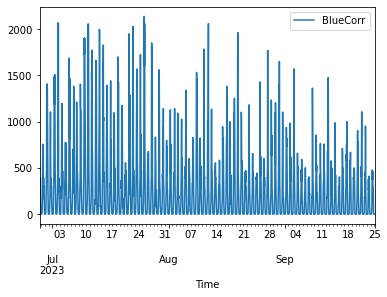

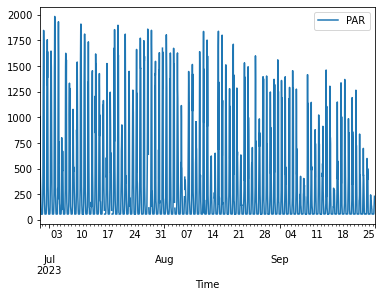

In [24]:
from sklearn.metrics import r2_score
import scipy

TestTTHour = TestTT.resample('H').mean()
BaseTTHour = BaseTT.resample('H').mean()
TestTTHour.plot(y = 'BlueCorr')
BaseTTHour.plot(y = 'PAR')

newindex = TestTTHour.index.union(BaseTTHour.index)
BaseTTHour = BaseTTHour.reindex(newindex)
TestTTHour = TestTTHour.reindex(newindex)
BaseTTHour = BaseTTHour[(~np.isnan(BaseTTHour['PAR']) & ~np.isnan(TestTTHour['BlueCorr']))] #Drop all NaN vals for R2 assesment
TestTTHour = TestTTHour[(~np.isnan(BaseTTHour['PAR']) & ~np.isnan(TestTTHour['BlueCorr']))]

print(np.sqrt(np.mean((BaseTTHour['PAR'] - TestTTHour['BlueCorr'])**2))) #RMSE
print(np.mean(np.abs(BaseTTHour['PAR'] - TestTTHour['BlueCorr']))) #MAE
print(np.mean((BaseTTHour['PAR'] - TestTTHour['BlueCorr']))) #ME
# r2score = r2_score(BaseTTHour['PAR'], TestTTHour['BlueCorr'])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(TestTTHour['BlueCorr'], BaseTTHour['PAR'])
print(r_value**2)
# print(r2score)